# Model fitting 1: Only SSC

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [2]:
print(jetset.__version__)

1.2.0rc13


In [3]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
print(test_SEDs[1])
data=Data.from_file(test_SEDs[1])


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv



***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



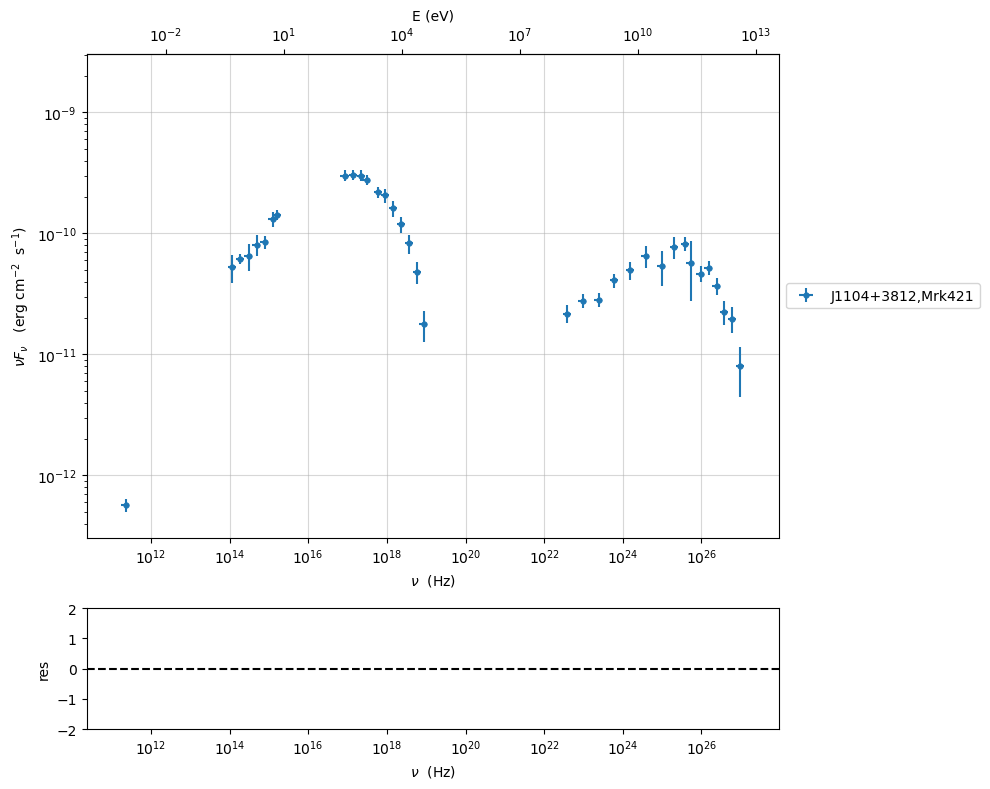

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()
#p.setlim(y_min=1E-15,x_min=1E7,x_max=1E29)

In [6]:
sed_data.save('Mrk_401.pkl')

## phenomenological model constraining

### spectral indices


*** evaluating spectral indices for data ***



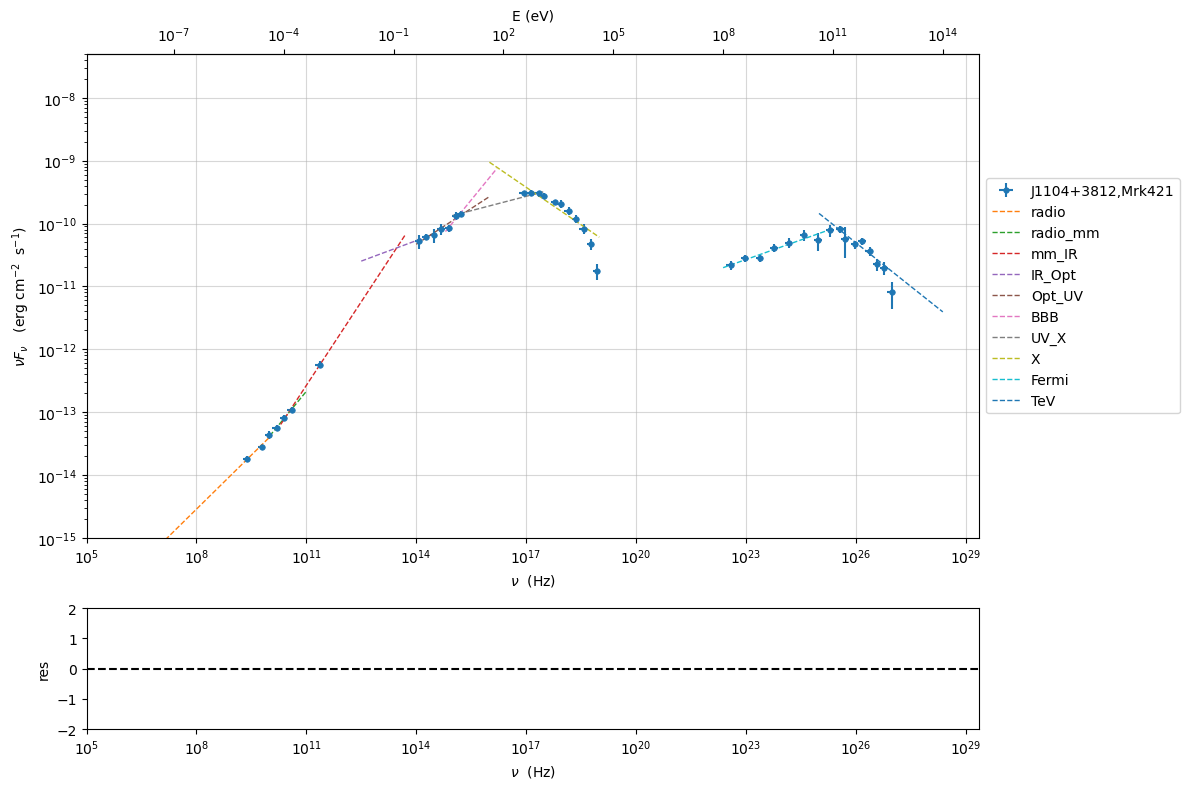

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=5E-8)

### sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.545300e-01,-1.545300e-01,9.534795e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.023245e-02,-1.023245e-02,1.433073e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.672267e+01,1.672267e+01,4.139942e-02,--,1.667039e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.491659e+00,-9.491659e+00,2.515285e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.672267e+01 (err=+4.139942e-02)  nuFnu_p=-9.491659e+00 (err=+2.515285e-02) curv.=-1.545300e-01 (err=+9.534795e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-2.098186e-01,-2.098186e-01,3.133032e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.661868e-02,-4.661868e-02,2.178352e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.524926e+01,2.524926e+01,1.147759e-01,--,2.529412e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.011085e+01,-1.011085e+01,3.498963e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.524926e+01 (err=+1.147759e-01)  nuFnu_p=-1.011085e+01 (err=+3.498963e-02) curv.=-2.098186e-01 (err=+3.133032e-02)



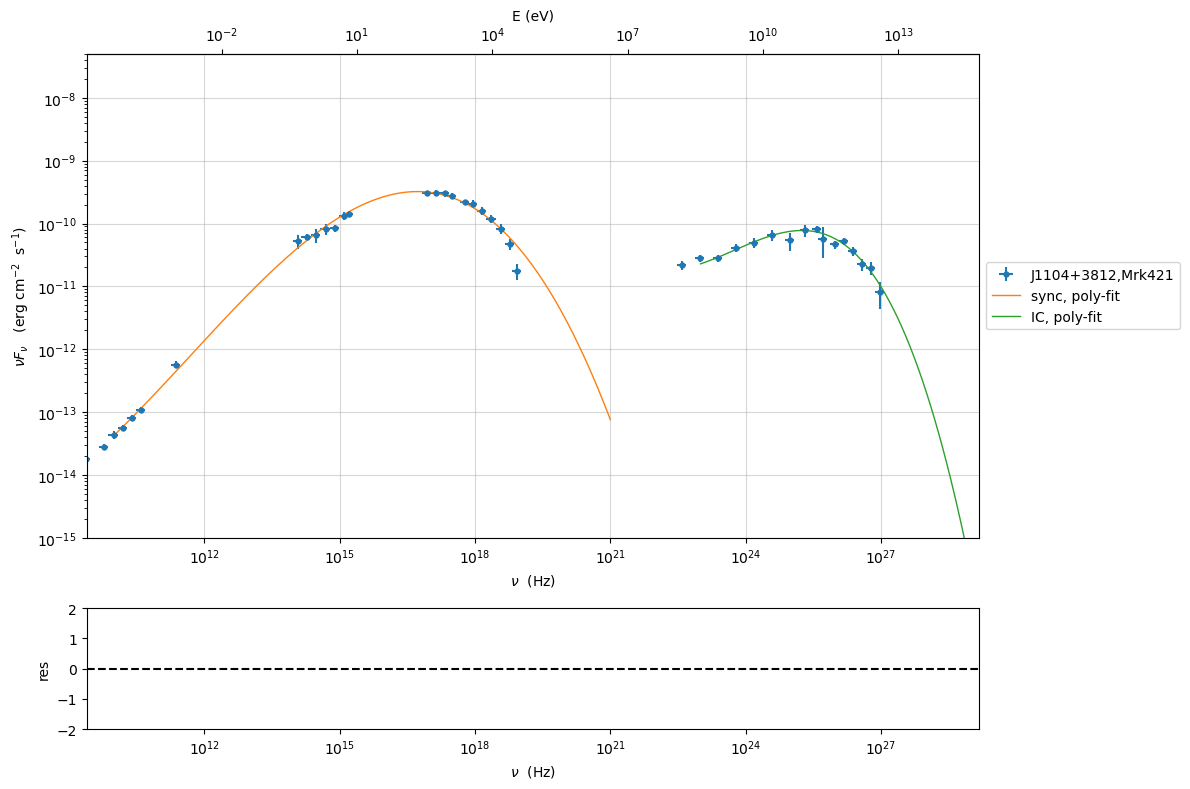

In [9]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15,y_max=5E-8)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


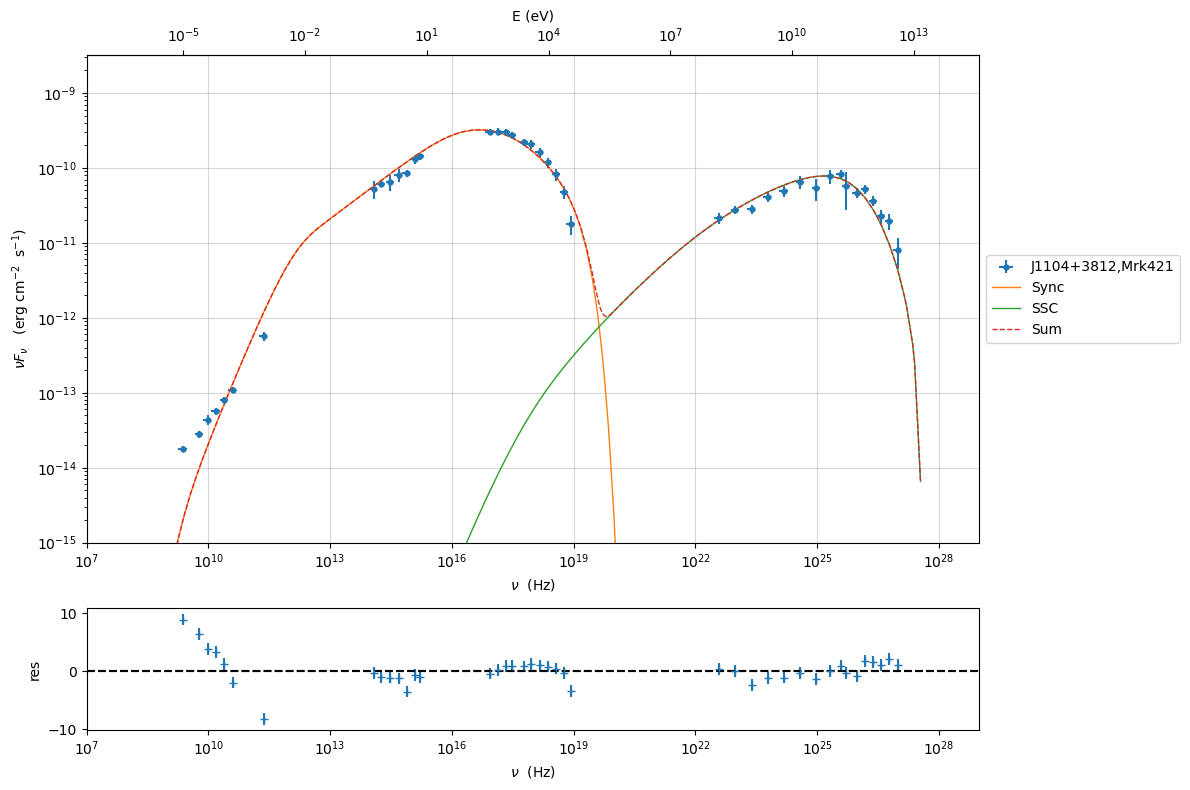

In [11]:
prefit_jet.eval()
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-15,x_min=1E7,x_max=1E29)

## Model fitting procedure

### Model fitting with LSB

In [12]:
from jetset.minimizer import fit_SED,ModelMinimizer

from jetset.model_manager import  FitModel
from jetset.jet_model import Jet


if you want to fit the `prefit_model` you can load the saved one (this allows you to save time) ad pass it to the `FitModel` class

In [13]:
prefit_jet=Jet.load_model('prefit_jet.pkl')
fit_model_lsb=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None) 


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


OR use the one generated above

In [14]:
fit_model_lsb=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None) 

In [15]:
fit_model_lsb.show_model_components()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


There is only one component, whit name `jet_leptonic`, that refers to the `prefit_jet` model component

We now set the gamma grid size to 200, ad we set `composite_expr`, anyhow, since we have only one component this step could be skipped

In [16]:
fit_model_lsb.jet_leptonic.set_gamma_grid_size(200)
fit_model_lsb.composite_expr='jet_leptonic'

### Freezeing parameters and setting fit_range intervals

These methods are alternative and equivalent ways to access a model component for setting parameters state and values 


a) passing as first argument, of the method, the model component `name`

b) passing as first argument, of the method, the model component `object`

c) accessing the model component member of the composite model class 

In [17]:
#a
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
#b
fit_model_lsb.freeze(prefit_jet,'R')
#c
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]

### Building the ModelMinimizer object

Now we build a `lsb` model minimizer and run the fit method

In [18]:
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,
                                     sed_data,
                                     1E11,
                                     1E29,
                                     fitname='SSC-best-fit-minuit',
                                     repeat=3)


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=5.32182e+01

fit run: 1
- old chisq=5.32182e+01


0it [00:00, ?it/s]

- best chisq=5.22603e+01

fit run: 2
- old chisq=5.22603e+01


0it [00:00, ?it/s]

- best chisq=5.09003e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.778915e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,9.191687e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.085652e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.337114e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.184444e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.644091e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,True
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.027056e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.334793e+01,1.000000e-04,--,False,False



converged=True
calls=63
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=27
chisq=50.900346, chisq/red=1.885198 null hypothesis sig=0.003576

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.778915e+02,4.778915e+02,2.699848e+02,--,4.697542e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,9.191687e+05,9.191687e+05,1.495007e+05,--,1.373160e+06,1.000000e+00,1.000000e+15,False
jet_leptonic,N,9.085652e-01,9.085652e-01,3.950026e-01,--,9.060842e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.337114e+04,4.337114e+04,2.937759e+04,--,3.188500e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.184444e+00,2.184444e+00,1.390250e-01,--,2.181578e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,7.644091e-01,7.644091e-01,2.758032e-01,--,7.726502e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.112712e+16,--,--,--,3.112712e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.027056e-02,5.027056e-02,1.208011e-02,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,2.334793e+01,2.334793e+01,3.239464e+00,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




we can obtain the best fit astropy table

In [19]:
best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,4.778915e+02,4.778915e+02,2.699848e+02,--,4.697542e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,9.191687e+05,9.191687e+05,1.495007e+05,--,1.373160e+06,1.000000e+00,1.000000e+15,False
jet_leptonic,N,9.085652e-01,9.085652e-01,3.950026e-01,--,9.060842e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.337114e+04,4.337114e+04,2.937759e+04,--,3.188500e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.184444e+00,2.184444e+00,1.390250e-01,--,2.181578e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,7.644091e-01,7.644091e-01,2.758032e-01,--,7.726502e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.112712e+16,--,--,--,3.112712e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.027056e-02,5.027056e-02,1.208011e-02,--,5.050000e-02,0.000000e+00,--,False


## saving fit model, model minimizer

We can save all the fit products to be used later.

In [20]:
best_fit_lsb.mesg=None
best_fit_lsb.save_report('SSC-best-fit-lsb.pkl')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

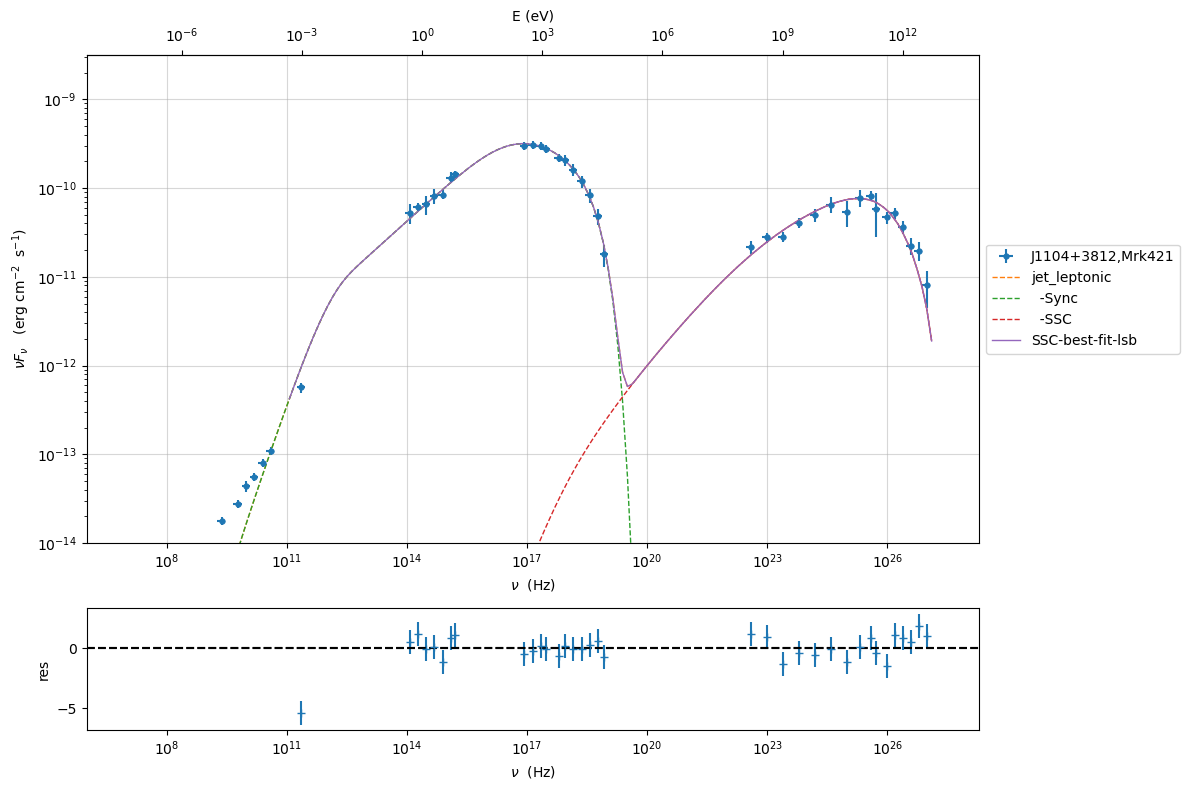

In [21]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

## Model fitting with Minuit

To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 

In [22]:
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_minuit=Jet.load_model('prefit_jet.pkl')
jet_minuit.set_gamma_grid_size(200)
#fit_model_minuit=fit_model_lsb
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=None) 

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [23]:
fit_model_minuit.show_model_components()



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


In [24]:

fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[5E15,1E17]
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E7]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,1E5]

fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5,50]

In [25]:
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10**11.,10**29.0,fitname='SSC-best-fit-minuit',repeat=2)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=4.33705e+01

fit run: 1
- old chisq=4.33705e+01


0it [00:00, ?it/s]

- best chisq=3.11482e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.688283e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,9.028968e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,7.917986e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.238465e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.090996e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,6.854517e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.046194e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.214133e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.249661e+01,1.000000e-04,--,False,False



converged=True
calls=2284
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 31.15                      │             Nfcn = 2284              │
│ EDM = 3.17e+06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │  0.47e3   │  0.29e3   │            │            │   10    │  1000   │       │
│ 1 │ par_1 │   0.9e6   │   2.0e6   │            │            │ 500000  │  1e+07  │       │
│ 2 │ par_2 │    0.8    │    0.8    │            │            │    0    │         │       │
│ 3 │ par_3 │  0.03e6   │  0.04e6   │            │            │  1000   │ 100000  │       │
│ 4 │ par_4 │     2     │     8     │            │            │   -10   │   10    │       │
│ 5 │ par_5 │     1     │    12     │            │            │   -15   │   15    │       │
│ 6 │ par_6 │ 0.030e18  │ 0.035e18  │            │            │  5e+15  │  1e+17  │       │
│ 7 │ par_7 │    0.1    │    0.4    │            │            │    0    │         │       │
│ 8 │ par_8 │    22     │    18     │            │            │    5    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8 │
├───────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │   9.3e+04  9.24e+07       -21 -3.93e+06  1.75e+03       906   1.8e+18      30.6      -220 │
│ par_1 │  9.24e+07  3.61e+12  1.29e+04  2.41e+09 -1.07e+06 -5.55e+05  -1.1e+21 -1.87e+04  1.35e+05 │
│ par_2 │       -21  1.29e+04     0.686      -548     0.244     0.126   2.5e+14   0.00426   -0.0307 │
│ par_3 │ -3.93e+06  2.41e+09      -548  2.02e+09  4.56e+04  2.36e+04  4.69e+19       797 -5.75e+03 │
│ par_4 │  1.75e+03 -1.07e+06     0.244  4.56e+04      75.3     -10.5 -2.09e+16    -0.355      2.56 │
│ par_5 │       906 -5.55e+05     0.126  2.36e+04     -10.5       219 -1.08e+16    -0.184      1.32 │
│ par_6 │   1.8e+18  -1.1e+21   2.5e+14  4.69e+19 -2.09e+16 -1.08e+16  1.75e+33 -3.65e+14  2.63e+15 │
│ par_7 │      30.6 -1.87e+04   0.00426       797    -0.355    -0.184 -3.65e+14    0.0905    0.0447 │
│ par_8 │      -220  1.35e+05   -0.0307 -5.75e+03      2.56      1.32  2.63e+15    0.0447       481 │
└───────┴───────────────────────────────────────────────────────────────────────────────────────────┘

dof=26
chisq=31.148172, chisq/red=1.198007 null hypothesis sig=0.222797

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.688283e+02,4.688283e+02,2.858882e+02,--,4.697542e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,9.028968e+05,9.028968e+05,1.970066e+06,--,1.373160e+06,5.000000e+05,1.000000e+07,False
jet_leptonic,N,7.917986e-01,7.917986e-01,7.826153e-01,--,9.060842e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.238465e+04,3.238465e+04,3.814239e+04,--,3.188500e+04,1.000000e+03,1.000000e+05,False
jet_leptonic,s,2.090996e+00,2.090996e+00,7.583699e+00,--,2.181578e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,6.854517e-01,6.854517e-01,1.250924e+01,--,7.726502e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.046194e+16,3.046194e+16,3.526875e+16,--,3.112712e+16,5.000000e+15,1.000000e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.214133e-02,5.214133e-02,3.594802e-01,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,2.249661e+01,2.249661e+01,1.845509e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




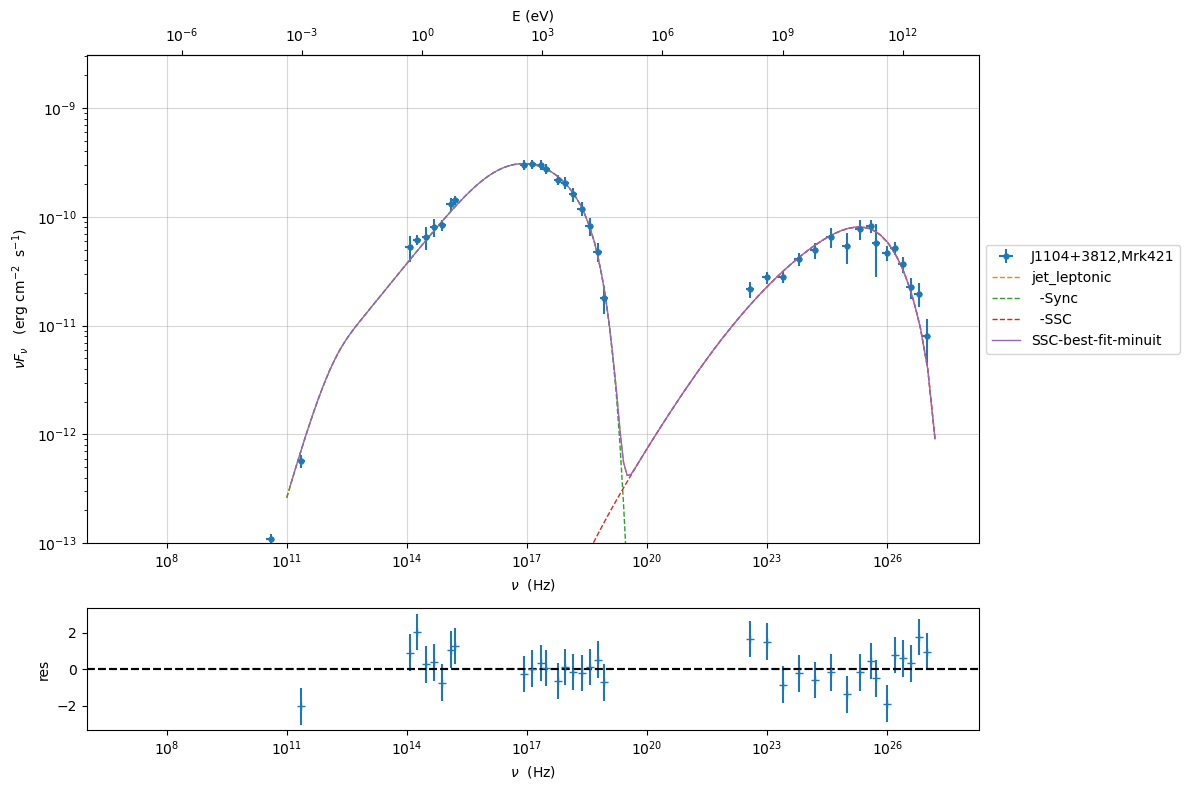

In [26]:
%matplotlib inline
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

In [27]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

You can obtain profile and contours, but this is typically time consuming. In any case, better results can be achieved using the MCMC approach (discussed in next section)
For further information regardin minuit please refer to https://iminuit.readthedocs.io

you can use also minos contour and profile, in this case the computational time is even longer:

## MCMC sampling

In [28]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used


In [29]:
from tqdm.auto import tqdm

model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_minuit.pkl')

mcmc=McmcSampler(model_minimizer_minuit)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict,progress='notebook')

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 283.30 seconds


In [30]:
print(mcmc.acceptance_fraction)

0.5660937500000001


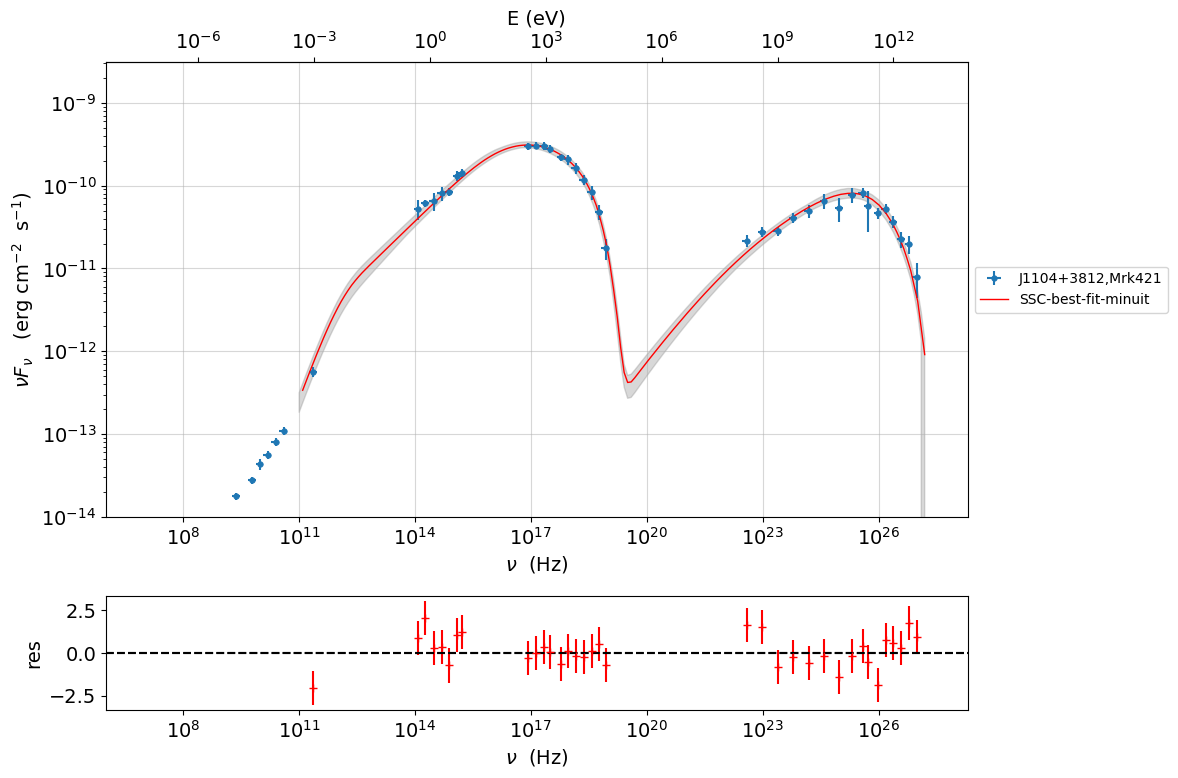

In [50]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11,2E28],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

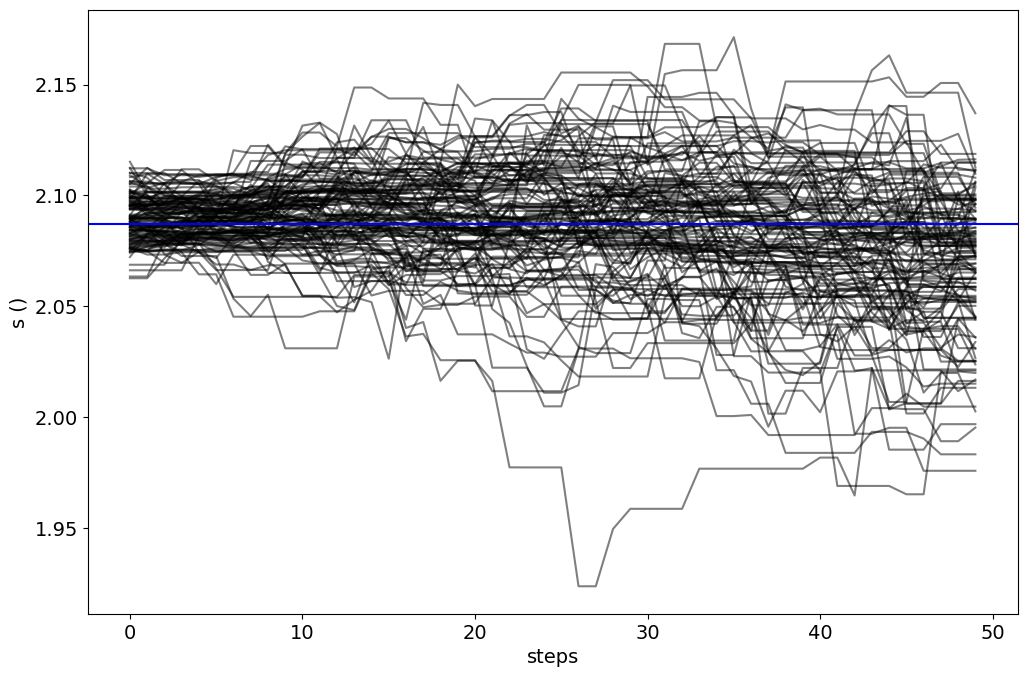

In [51]:
f=mcmc.plot_chain('s',log_plot=False)

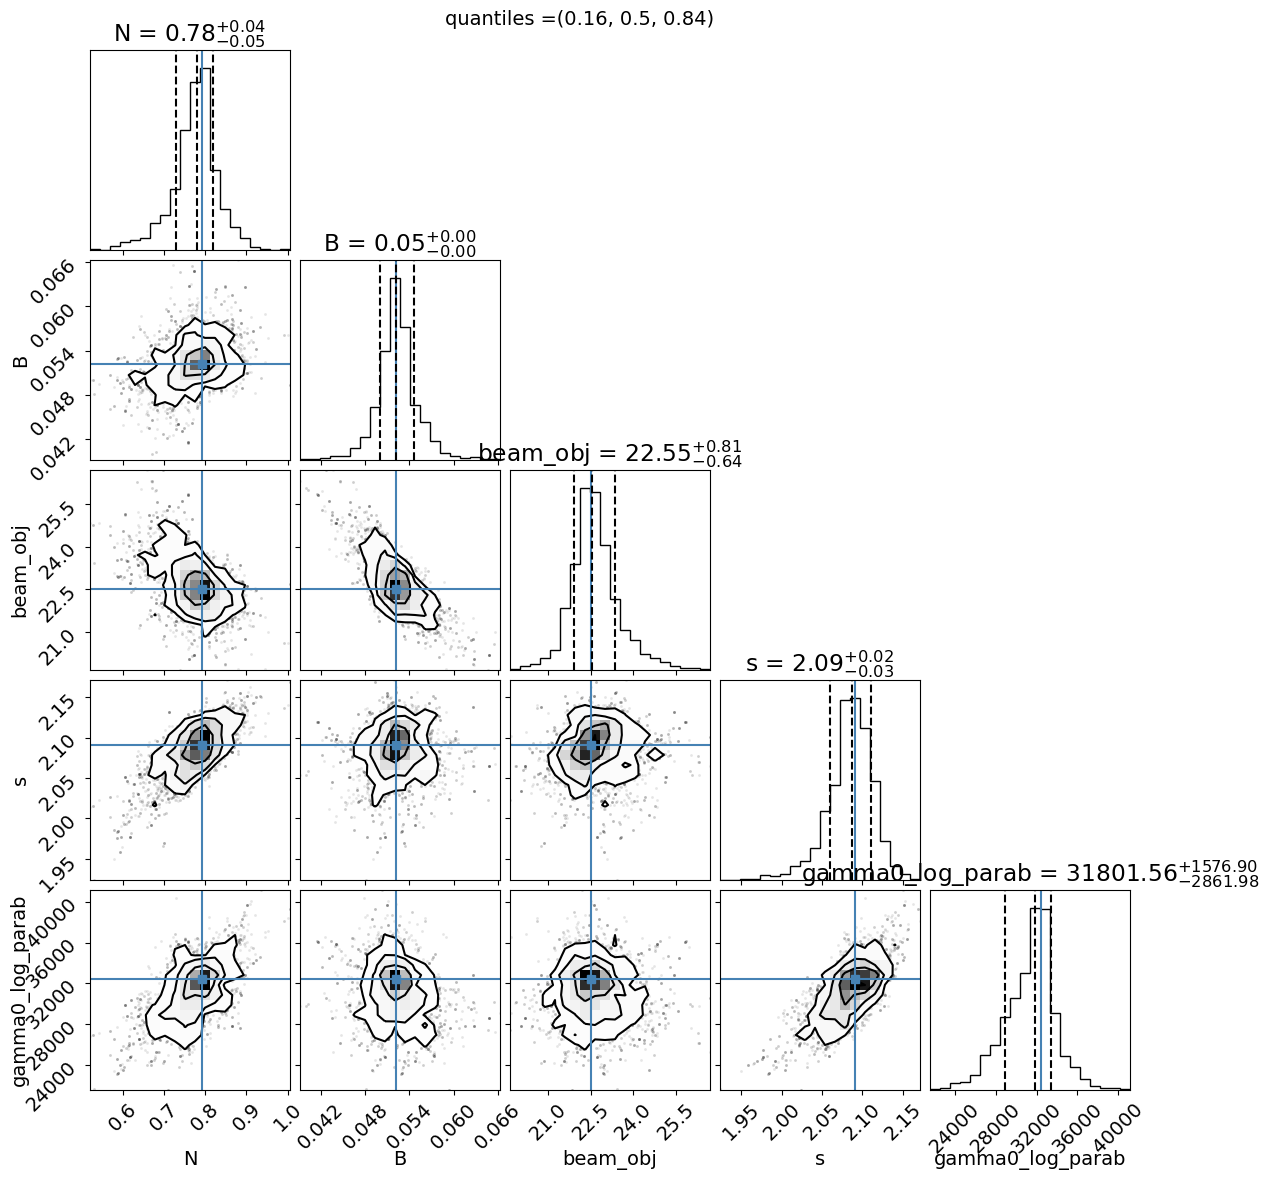

In [52]:
f=mcmc.corner_plot()

In [53]:
mcmc.get_par('N')

(array([0.79581428, 0.78757822, 0.79556317, ..., 0.80158494, 0.75293999,
        0.77280407]),
 0)

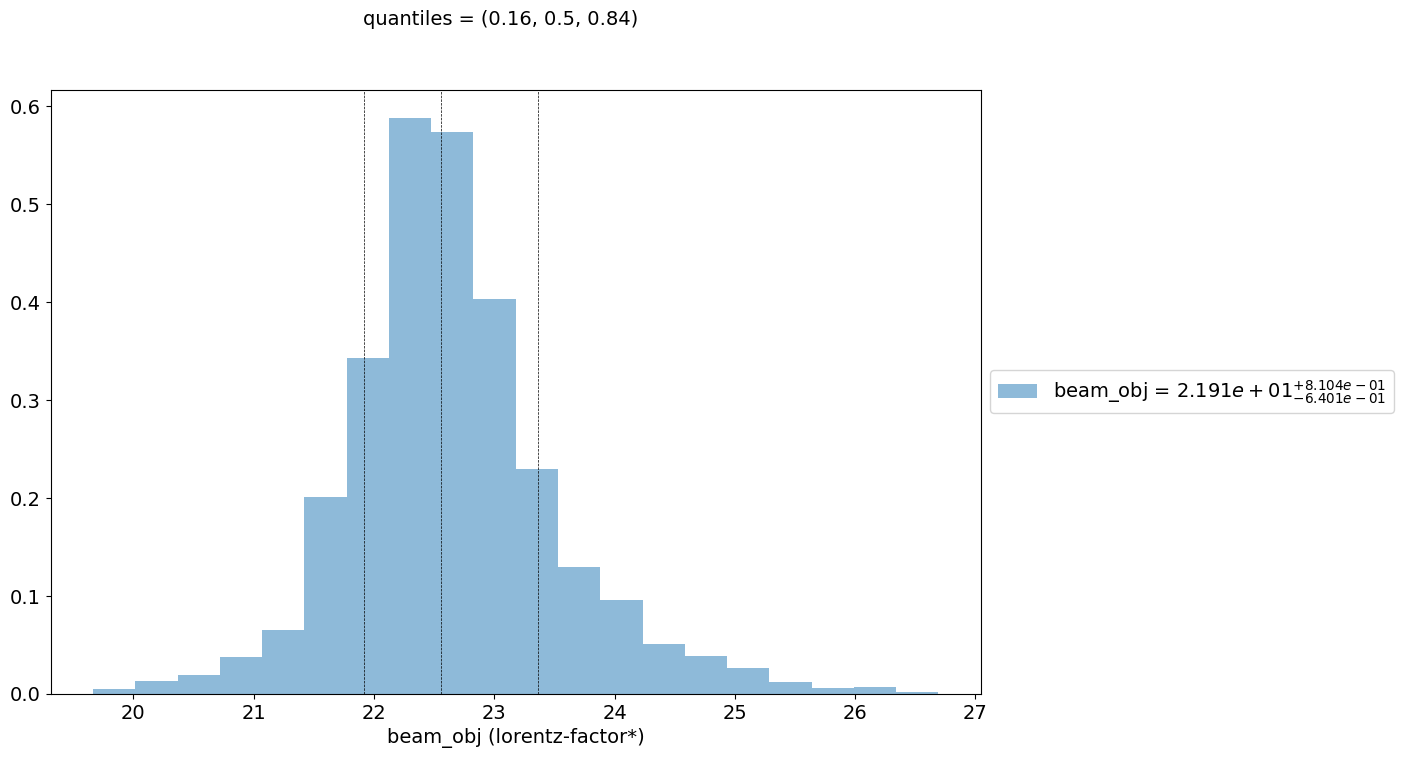

In [54]:
f=mcmc.plot_par('beam_obj')

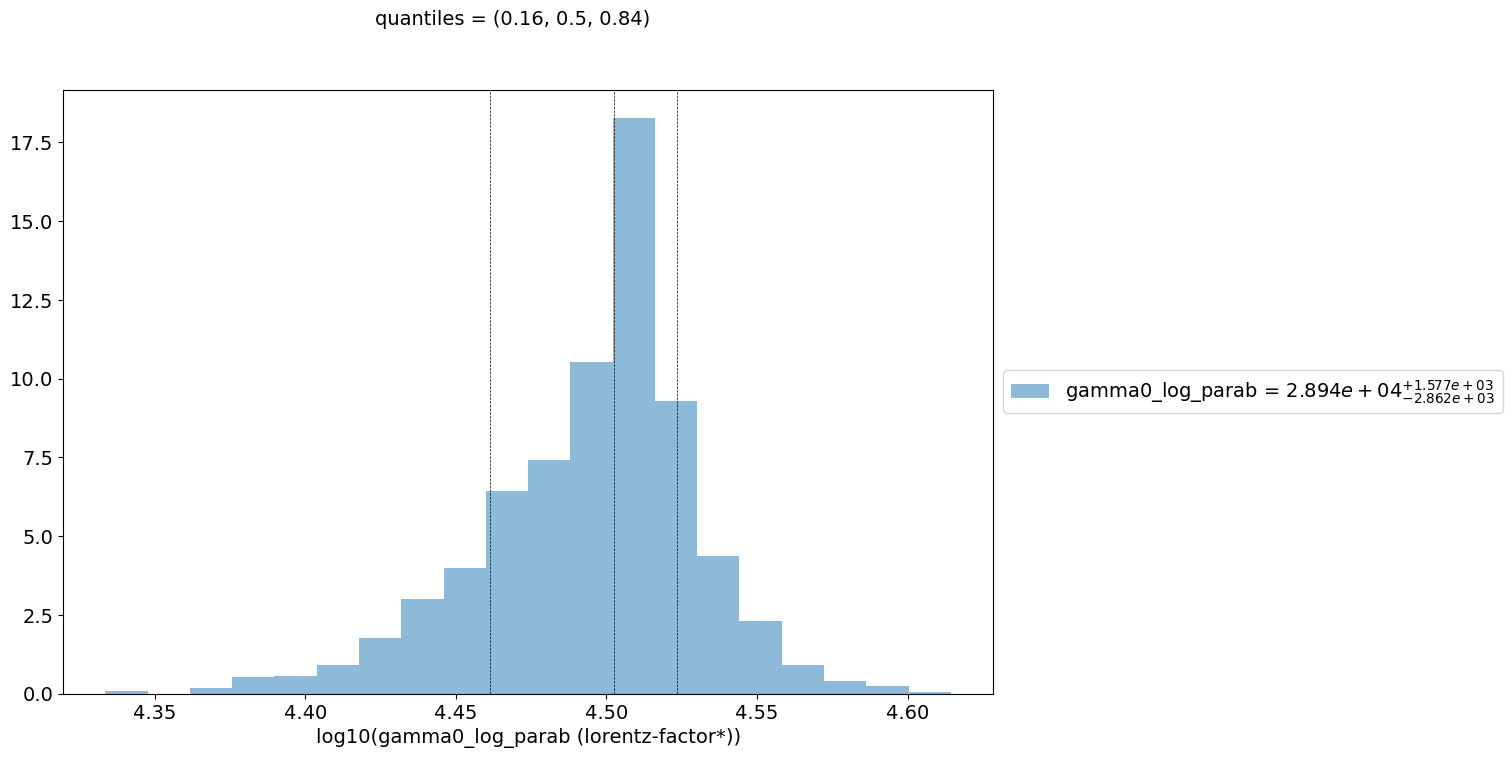

In [55]:
f=mcmc.plot_par('gamma0_log_parab',log_plot=True)

## Save and reuse MCMC

In [56]:
mcmc.save('mcmc_sampler.pkl')

In [57]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_401.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

In [58]:
ms.model.name

'SSC-best-fit-minuit'

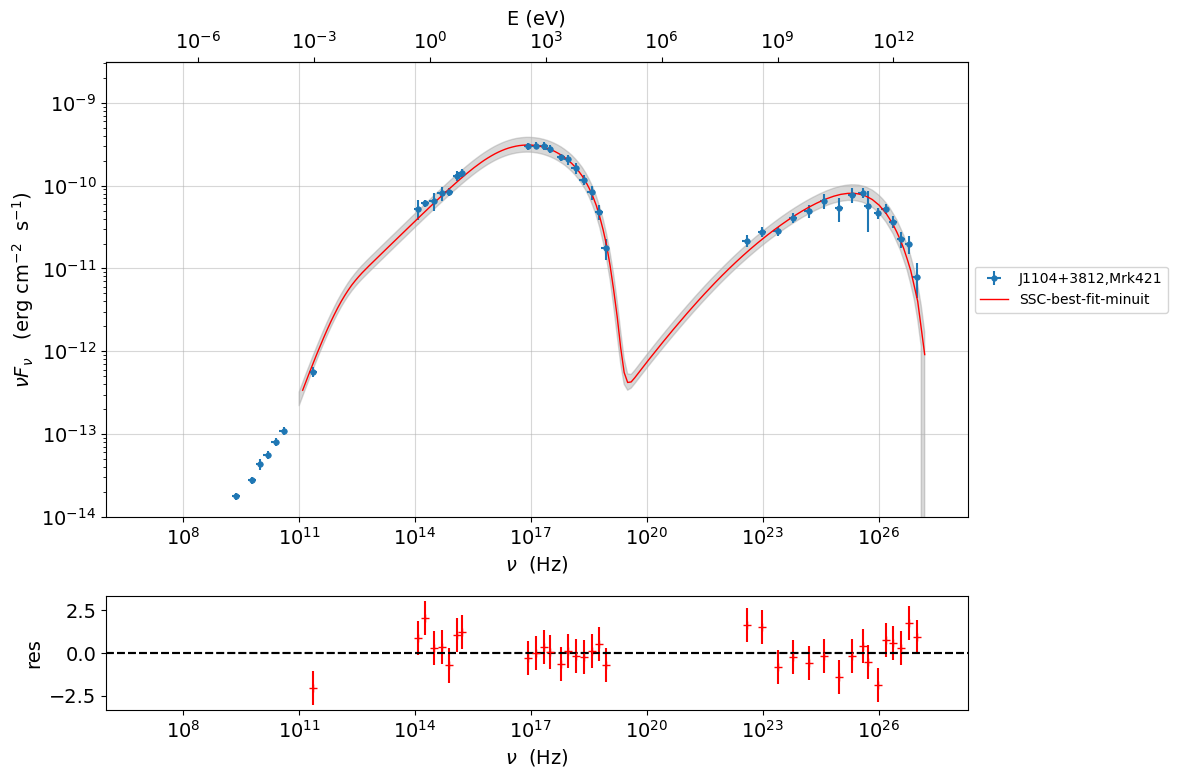

In [59]:
p=ms.plot_model(sed_data=sed_data,fit_range=[1E11, 2E27],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

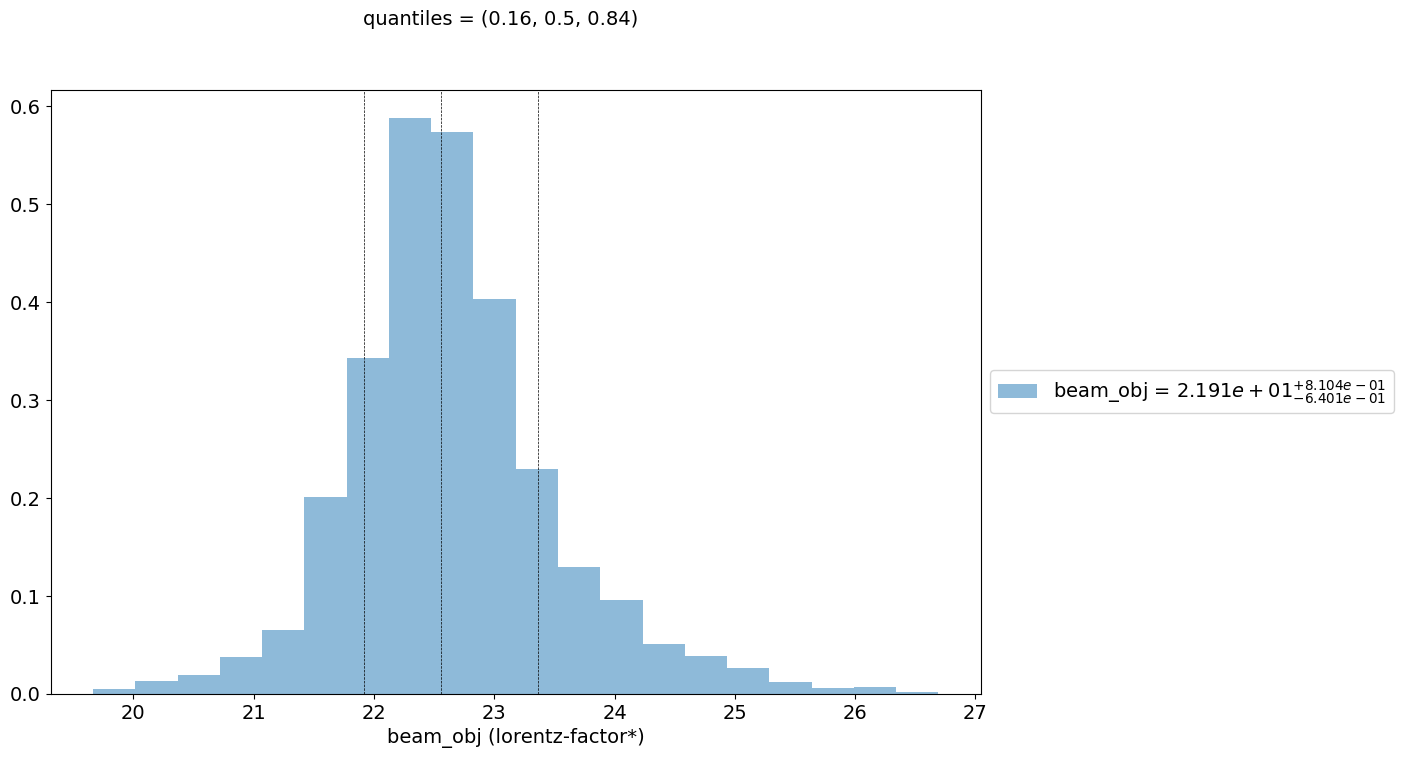

In [60]:
f=ms.plot_par('beam_obj',log_plot=False)


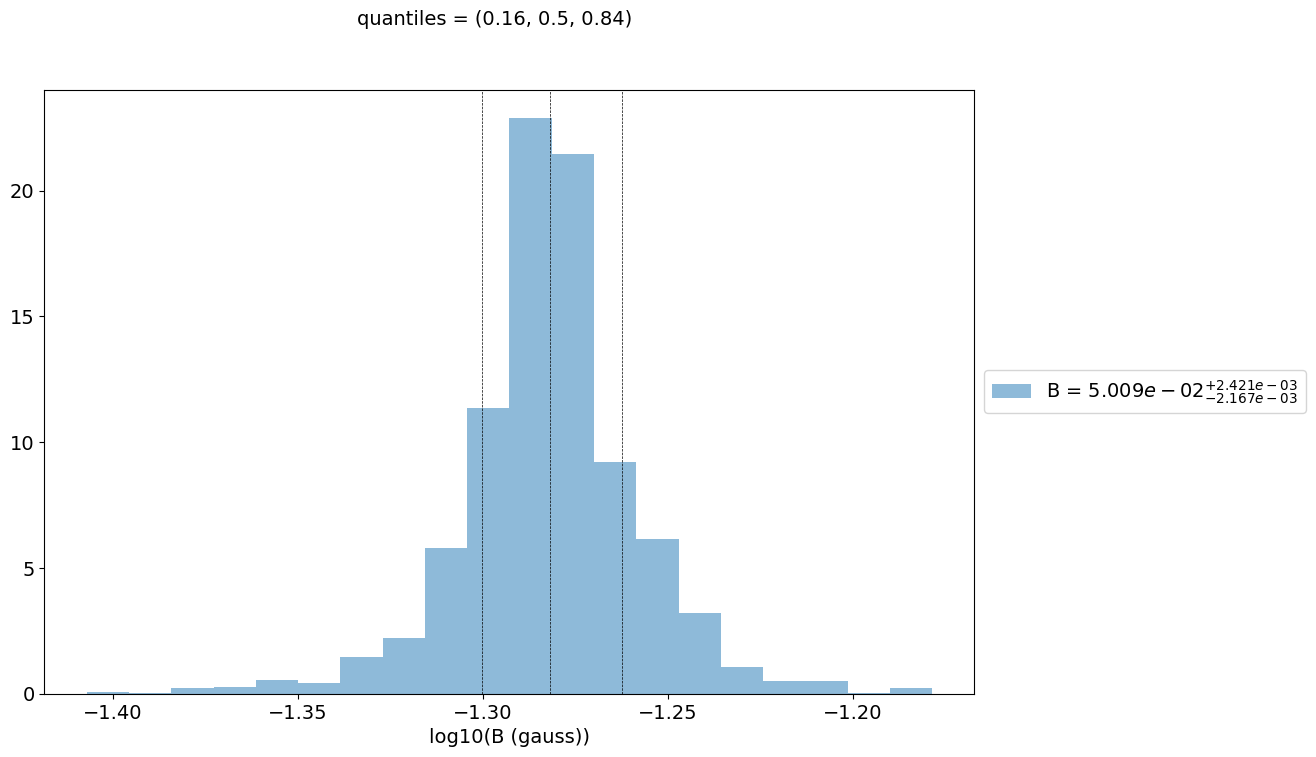

In [61]:
f=ms.plot_par('B',log_plot=True)


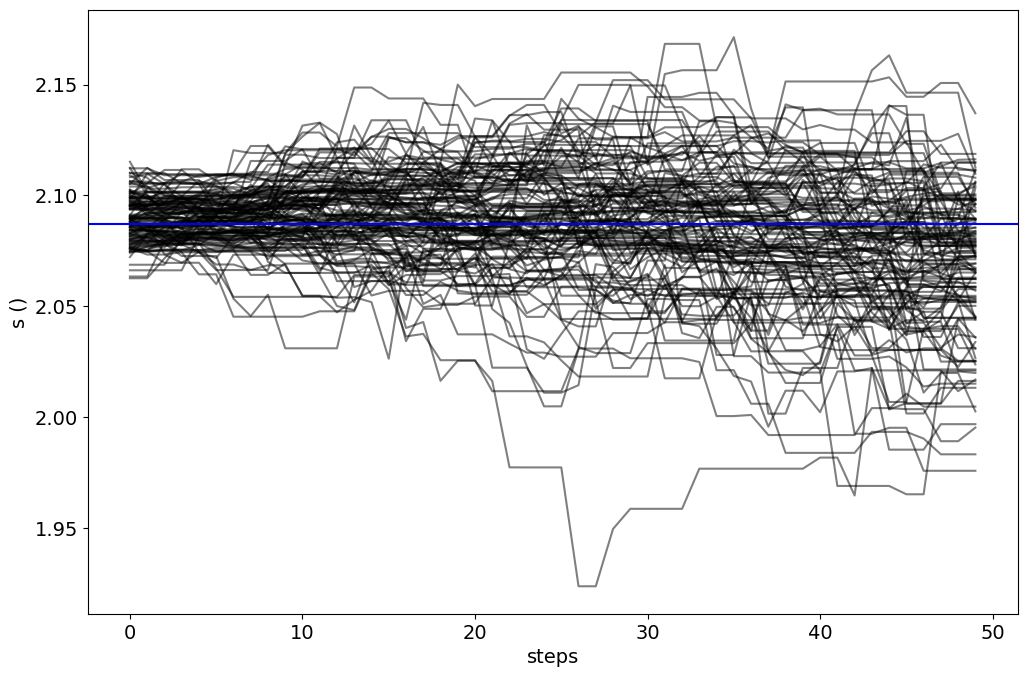

In [62]:
f=ms.plot_chain('s',log_plot=False)

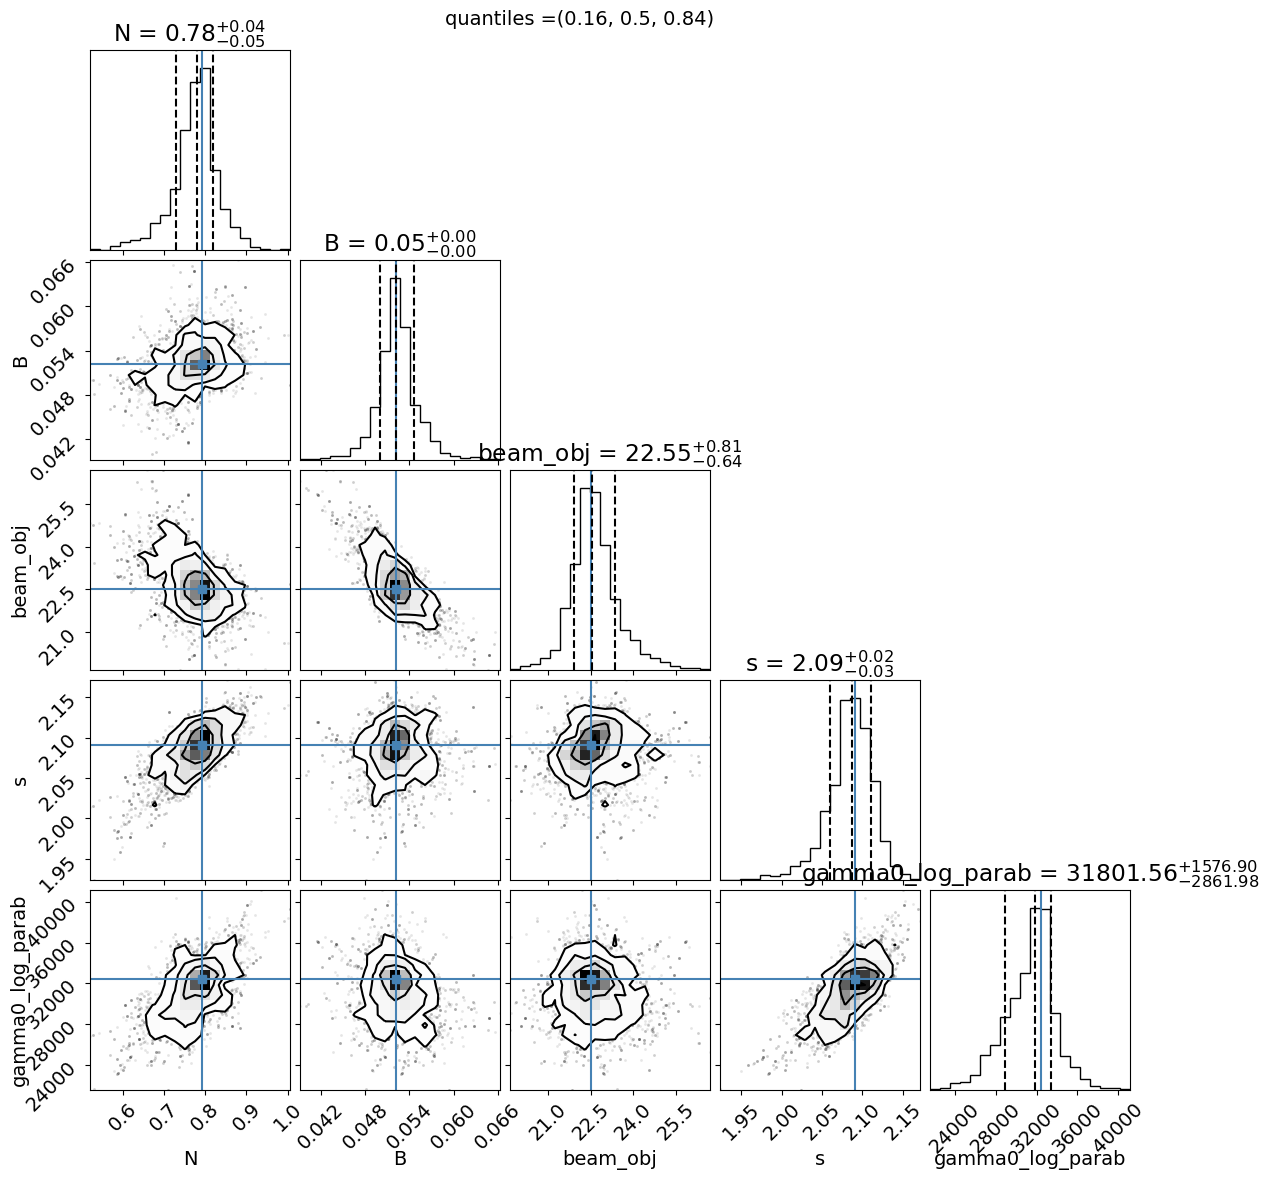

In [63]:
f=ms.corner_plot()